In [1]:
# Install required libraries
!pip install wordcloud matplotlib requests nltk gensim pyLDAvis

    extract-msg (<=0.29.*)
                 ~~~~~~~^


In [2]:
# Import libraries
import requests
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import nltk
import re
import gensim
from gensim import corpora
import pyLDAvis.gensim_models

C:\Users\Hetal\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Download NLTK resources
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hetal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Step 2: Fetch News Data from the API
API_KEY = 'd838bdc663db485e8a797843eb388dbe'  # Replace with your News API key
url = f'https://newsapi.org/v2/everything?q=technology&apiKey={API_KEY}'  # Query for 'technology'
response = requests.get(url)
data = response.json()

In [5]:
# Step 3: Combine the content from articles into a DataFrame
articles = data['articles']
df = pd.DataFrame(articles)
df['content'] = df['description'].fillna('') + ' ' + df['title'].fillna('')

In [6]:
# Step 4: Data Cleaning
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = text.lower()  # Convert to lowercase
    return ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords

In [7]:
# Clean the content
df['cleaned'] = df['content'].apply(clean_text)

In [8]:
# Step 5: Prepare for LDA
texts = df['cleaned'].apply(lambda x: x.split())
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [9]:
# Step 6: Apply LDA with 10 topics
num_topics = 15  # You can change this to 15 for more topics
lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

In [10]:
# Step 7: Get the top 5 topics
topic_counts = [0] * num_topics

In [11]:
# Count occurrences of each topic across all documents
topic_distribution = lda_model.get_document_topics(corpus)
for doc in topic_distribution:
    for topic_id, prob in doc:
        topic_counts[topic_id] += prob

# Get indices of top 5 topics sorted by their counts
top_topic_indices = sorted(range(num_topics), key=lambda i: topic_counts[i], reverse=True)[:5]
top_counts = [topic_counts[i] for i in top_topic_indices]

# Get descriptive topic names using the top word for each topic
topic_names = []
for i in top_topic_indices:
    words = lda_model.show_topic(i, topn=1)  # Get the top word for the topic
    topic_name = words[0][0]  # Use the first word as the topic name
    topic_names.append(topic_name)

In [12]:
# Step 7: Generate the Word Cloud
wordcloud_text = ' '.join([word for topic in lda_model.show_topics(formatted=False, num_words=100) for word, _ in topic[1]])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)

In [13]:
# Step 8: Save the Word Cloud to an image file
wordcloud.to_file('word_cloud.png')

In [14]:
# Step 9: Create an HTML file with clickable words
def create_html(wordcloud):
    words = wordcloud.words_  # Get the words and their frequencies
    html_content = '''
    <html>
    <body>
        <h1>Word Cloud</h1>
        <h2>Click on a word to see related articles</h2>
        <div style="display: flex; flex-wrap: wrap;">
    '''
    
    # Loop through each word and add a link
    for word, freq in words.items():
        google_news_url = f'https://news.google.com/search?q={word}'
        html_content += f'<a href="{google_news_url}" target="_blank" style="margin: 5px; font-size: {int(freq * 100)}px; text-decoration: none; color: black;">{word}</a> '
    
    html_content += '''
        </div>
    </body>
    </html>
    '''
    
    # Write HTML content to a file
    with open('word_cloud.html', 'w') as f:
        f.write(html_content)

# Call this function after generating the word cloud
create_html(wordcloud)

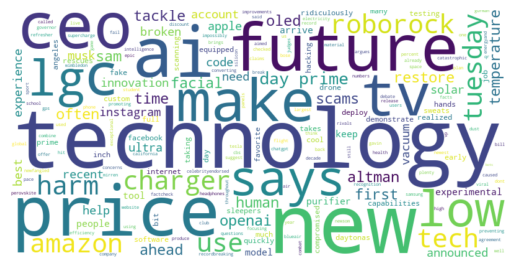

In [15]:
# Step 11: Display the word cloud image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
# Step 12: Prepare LDA Visualization
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_visualization.html')  # Save to an HTML file to view in a browser

In [17]:
lda_model.show_topics()

[(2,
  '0.034*"ai" + 0.015*"technology" + 0.015*"bill" + 0.008*"new" + 0.008*"fortnite" + 0.008*"youth" + 0.008*"sports" + 0.008*"offers" + 0.008*"gates" + 0.008*"firstperson"'),
 (6,
  '0.015*"technology" + 0.011*"wifi" + 0.011*"apple" + 0.011*"two" + 0.011*"ai" + 0.008*"satellite" + 0.008*"citadel" + 0.008*"securities" + 0.008*"plugs" + 0.008*"sensing"'),
 (0,
  '0.017*"technology" + 0.011*"dodge" + 0.011*"semisolidstate" + 0.011*"batteries" + 0.011*"using" + 0.011*"qr" + 0.011*"helen" + 0.011*"debate" + 0.011*"cobain" + 0.011*"missing"'),
 (1,
  '0.023*"apple" + 0.022*"day" + 0.022*"prime" + 0.019*"technology" + 0.015*"max" + 0.014*"amazon" + 0.012*"advanced" + 0.012*"bad" + 0.012*"battery" + 0.012*"airpods"'),
 (10,
  '0.019*"garmin" + 0.019*"apple" + 0.010*"might" + 0.010*"technology" + 0.010*"predict" + 0.010*"infosys" + 0.010*"bcg" + 0.010*"companies" + 0.010*"bees" + 0.010*"aarp"'),
 (4,
  '0.025*"technology" + 0.017*"test" + 0.013*"preview" + 0.013*"safari" + 0.013*"apple" + 0

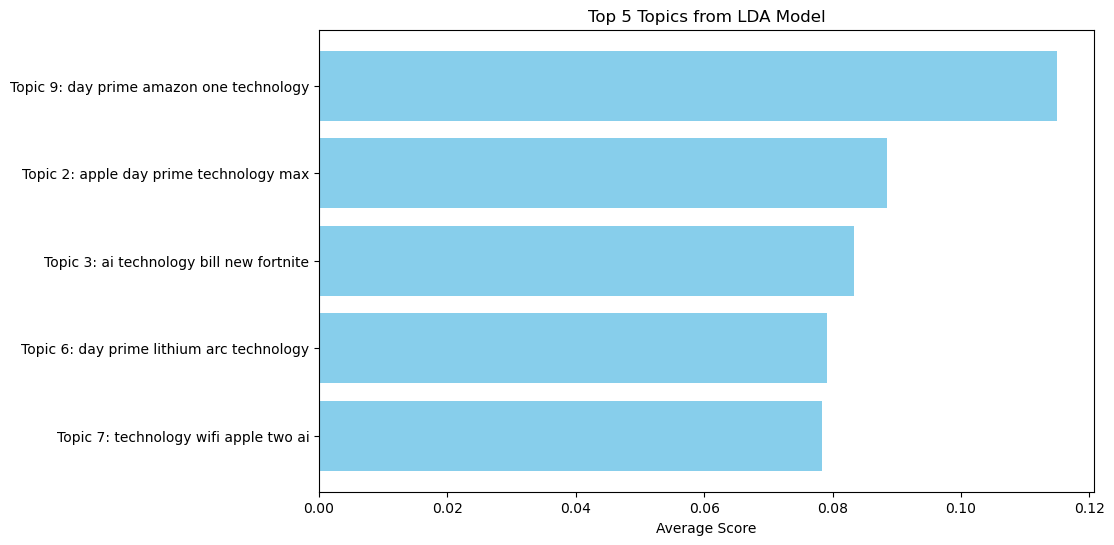

In [18]:
# Step 7: Get topic scores and names for the top 5 topics
topic_scores = lda_model.get_document_topics(corpus)
topic_avg_scores = [0] * lda_model.num_topics
for doc_topics in topic_scores:
    for topic_id, score in doc_topics:
        topic_avg_scores[topic_id] += score

topic_avg_scores = [score / len(corpus) for score in topic_avg_scores]  # Normalize scores
top_topic_ids = sorted(range(len(topic_avg_scores)), key=lambda i: topic_avg_scores[i], reverse=True)[:5]

# Step 8: Generate names for the top topics
top_topic_names = []
top_scores = []
for topic_id in top_topic_ids:
    words = lda_model.show_topic(topic_id, 5)  # Get top words
    topic_name = " ".join([word for word, _ in words])  # Create a simple name
    top_topic_names.append(f'Topic {topic_id + 1}: {topic_name}')
    top_scores.append(topic_avg_scores[topic_id])  # Append score for plotting

# Step 9: Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_topic_names, top_scores, color='skyblue')
plt.xlabel('Average Score')
plt.title('Top 5 Topics from LDA Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest score on top
plt.show()